#### This notebook explains the modeling and training process

### Table of content

** I. Import Neccessary libraries <br>
II. Import Dataset <br>
III. Data Cleansing and processing <br>
IV. Initializing the neural network <br>
V. Model Training **

--

## I. Import Neccessary Libraries

In [1]:
### If missing any library, please uncomment the repective line below and pip install
#!pip install tensorflow --upgrade
#!pip install h5py
#!pip install numpy --upgrade
#!pip install pandas
#!pip install dask --upgrade

## Taken from https://pypi.org/project/pygeohash/
## Using this instead of the python-geohash by hiwi due to better documentation

#!pip install pygeohash


In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pygeohash as pgh
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import random
import math
import pickle
tqdm_notebook.pandas()
%matplotlib inline

C:\Users\Coddy\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## II. Import the Dataset

#### 1. Spilting the training dataset (sorely for github)
Had an issue where github do not allow commit above 100MB.<br>
My laptop had several issues in regarding the usage of github-lfs for large file<br>
Thus I spilt them up into two 80~ MB files, and combine them later in the code

#### 2. Loading the dataset

In [3]:
df1 = pd.read_csv("training_1st_half.csv")
df2 = pd.read_csv("training_2nd_half.csv")
df = df1.append(df2, ignore_index = True)

An brief overview of the dataset

In [4]:
print("The dataset has " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns")  # 4,206,321 entries
print("A brief summary of numerical columns:")
print(df.describe())
print("First five rows of the dataset:")
print(df.head())

The dataset has 4206321 rows and 4 columns
A brief summary of numerical columns:
                day        demand
count  4.206321e+06  4.206321e+06
mean   3.145299e+01  1.050907e-01
std    1.768278e+01  1.592655e-01
min    1.000000e+00  3.092217e-09
25%    1.600000e+01  1.867379e-02
50%    3.200000e+01  5.043463e-02
75%    4.700000e+01  1.208644e-01
max    6.100000e+01  1.000000e+00
First five rows of the dataset:
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468


## III. Data cleansing and processing

#### 1. Combine day and timestamp columns to time_stamp column
This column measure the index of timestamp from day 1 first time stamp (0) to day 61 last timestamp (5855)

In [5]:
def string_to_time (string):
    x = string.split(":")
    timing = int(x[0]) * 60 + int(x[1])
    return timing/15

df['time_stamp'] = df['timestamp'].progress_apply(string_to_time)
df['time_stamp'] = df['time_stamp'] + (df['day'] - 1)*96
df.head()

A Jupyter Widget

,geohash6,day,timestamp,demand,time_stamp
0,qp03wc,18,20:0,0.020072,1712.0
1,qp03pn,10,14:30,0.024721,922.0
2,qp09sw,9,6:15,0.102821,793.0
3,qp0991,32,5:0,0.088755,2996.0
4,qp090q,15,4:0,0.074468,1360.0


In [6]:
df.describe()   ##Time stamp from 0 to 5855 (5856 = 61 x24 x 4)

,day,demand,time_stamp
count,4.206321e+06,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01,2.964249e+03
std,1.768278e+01,1.592655e-01,1.697748e+03
min,1.000000e+00,3.092217e-09,0.000000e+00
25%,1.600000e+01,1.867379e-02,1.477000e+03
50%,3.200000e+01,5.043463e-02,3.010000e+03
75%,4.700000e+01,1.208644e-01,4.428000e+03
max,6.100000e+01,1.000000e+00,5.855000e+03


#### 2. Identify unique geohash6-s
A total of 1329 unique geohash markers

In [7]:
de = df.groupby(['geohash6']).count()
hash_list = de.index.values
hash_list = np.squeeze(hash_list)
print(len(hash_list))
hash_list

1329


array(['qp02yc', 'qp02yf', 'qp02yu', ..., 'qp0dnh', 'qp0dnj', 'qp0dnn'],
      dtype=object)

#### 3. Pivot the original 4206321 by 4 dataframe to time_stamp vs geohash6 (5847 by 1329)
There's 5856 - 5847 = 9 timestamps where no demand is observed in any geohash<br>
The dataframe is then filled with 0 to replace NaN to prevent any numerical calculation errors

In [8]:
df = pd.pivot_table(df, values='demand', index=['time_stamp'],columns=['geohash6'])
df = df.fillna(0)
print(df.shape)
df.head()

(5847, 1329)


geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,...,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
time_stamp,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0006,...,0.0,0.0,0.004056,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.009381,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.008253,0.0,0.0,0.0,0.0,0.0,0.002701,0.0


#### 4. Converting the time_stamp vs geohash6 table to a list of historical data for each demand entry to be the input of model
This is the most difficult part of the data processing section.<br><br>
I would like to sample past 13 days record for each entry, if applicable( to be safe from exceeding limit of up to 14days, also to reduce dataframe size to a small extent)<br>
However this will add additonal 13 x 24 x 4 -1 = 1247 columns to the existing dataset, rendering it impossible to be handled on local server due to memory issues in processing a ~ 4millon by 1250 dataframe. (roughly 180 GB of RAM for such df)<br><br>
To tackle this, I adopt the minibatch technique and use a random sampling method to sample 20 geohash using a rolling window technique on the training dataset.<br> This provides me with roughly 50,000 entries for each sampling frame as training set. <br><br>
By keeping the parameters from previous learning cycles and resampling training set, this repeated process will achieve an approximate accuracy of training on the entire dataset (minibatch idea)<br>
The development set is not resampled, as it is a very small.<br><br>
**Training and Development set format**:<br>
**Features consisting of**:<br>
1248 columns of demand from timestamp = T-1248 to timestamp = T-1<br>
1 column of the demand at timestamp = T<br>
2 columns of geohash6 data in terms of latitude and longitude. This is decoded using pygeohash library <br>
**Targets being**:<br>
5 columns the demand at timestamp = T+1 to timestamp = T+5 <br>
**This makes a total of 1251 features and 5 targets **

In [9]:
def resampling(df,seed = 10):
    '''
    This function takes in 3 arguments: a training dataframe, a limit (int) and a seed (int) for randomization
    
    This function randomly pick 30 geohash6 from the list of available geohash6 in the training dataframe based on the seed
    It then perform a rolling window of 1248 + 1 + 5 = 1254 width on the dataframe's subset of only the selected geohash6-s
    It then append the result of the rolling window as well as the decoded geohash to the X and Y dataframe respectively
    It repeats until the X (or Y, same length) exceed length of limit argument or when all 30 geohash6 are completed.
    
    This function returns the training X and Y of the randomed sample
    '''
    X = pd.DataFrame({"index":list(np.core.defchararray.add("T-",np.arange(1248,0,-1).astype("str")))+\
                           ["T","lat","lon"]})
    Y = pd.DataFrame({"index":["T+1","T+2","T+3","T+4","T+5"]})
    
    hash_list = df.T.index.values
    
    random.seed(seed)
    try:
        sample = random.sample(range(0, len(hash_list)), 10)
    except:
        sample = hash_list
    k=0
    sampled_list = []
    for geohash in tqdm_notebook(hash_list[sample]):
        lat = pgh.decode(geohash)[0]
        lon = pgh.decode(geohash)[1]
        for i in range(1248,df.shape[0]-5):
            if df[geohash].values[i] > 0:
                k+=1
                X[str(k)] = list(df[geohash].values[i-1248:i+1])+[lat,lon]
                Y[str(k)] = list(df[geohash].values[i+1:i+6])
        sampled_list += [geohash]
        
    print(len(sampled_list),"Geohash-s sampled,",len(hash_list)-len(sampled_list)," remaining")

    X=np.array(X.T.drop(['index'])).astype("float")
    Y=np.array(Y.T.drop(['index'])).astype("float")
    
    print("This sample has:",k,"rows")
    
    return X,Y ,sampled_list

In [10]:
def dev_sampling(df):
    '''
    This function takes in 1 argument: a dataframe
     
    This function performs a rolling window of 1248 + 1 + 5 = 1254 width on the dataframe
    It then append the result of the rolling window as well as the decoded geohash to the X and Y dataframe respectively
    It repeats until it loops through the entire dataframe
    
    This function returns the dev X and Y of the randomed sample
    '''
    X = pd.DataFrame({"index":list(np.core.defchararray.add("T-",np.arange(1248,0,-1).astype("str")))+\
                           ["T","lat","lon"]})
    Y = pd.DataFrame({"index":["T+1","T+2","T+3","T+4","T+5"]})
    
    hash_list = df.T.index.values
    
    k=0

    for geohash in tqdm_notebook(hash_list):
        lat = pgh.decode(geohash)[0]
        lon = pgh.decode(geohash)[1]
        for i in range(1248,df.shape[0]-5):
            if df[geohash].values[i] > 0:
                try:
                    k+=1
                    X[str(k)] = list(df[geohash].values[i-1248:i+1])+[lat,lon]
                    Y[str(k)] = list(df[geohash].values[i+1:i+6])
                except:
                    k+=1
                    print(df[geohash].values[i])
                    print(list(df[geohash].values[i-1248:i+6])+[geohash])
                    
    X=np.array(X.T.drop(['index'])).astype("float")
    Y=np.array(Y.T.drop(['index'])).astype("float")
    
    print("This sample has:",k,"rows")
    
    return X,Y

**I used a train testt split of 99% training and 1% testing.<br>
This gives me 14 geohashs of data in the developement set **

In [11]:
train,dev = train_test_split(df.T, test_size=0.01, random_state=42)

**A mock sampling of training set** (used to debug the initiation of neural network)

In [12]:
# train_X_0, train_Y_0,_ = resampling(train.T,99)
# print("Training set have the shape of:",(train_X_0.shape,train_Y_0.shape))

**Sampling of the development set** <br>
Loading from existing set (seed = 42), if possible

In [13]:
try:
    dev_X = pd.read_csv("devX.csv").values
    dev_Y = pd.read_csv("devY.csv").values
    print("Loaded Development set have the shape of:",(dev_X.shape,dev_Y.shape))
except:
    dev_X,dev_Y = dev_sampling(dev.T)
    print("Reloaded Development set have the shape of:",(dev_X.shape,dev_Y.shape))
    pd.DataFrame(dev_X).to_csv("devX.csv", index_label = False)
    pd.DataFrame(dev_Y).to_csv("devY.csv", index_label = False)

Loaded Development set have the shape of: ((40698, 1251), (40698, 5))


## IV. Initializing the Neural Network Model

### 1. Preparation

**A 3 layers neural network with tensorflow framework was used for this challenge.**<br>
<br>
The layers are of following:<br>
L-0: Input layer of 1251 features <br>
L-1: A hidden layer of 250 features <br>
L-2: A hidden layer of 50 features <br>
L-3: A predicting layer of 5 features<br><br>
<br>
The pipline is Linear - Relu - Linear - Relu - Linear <br>
Cost is measured by mean square error, same as required in the challenge<br>
<br>
Due to memory issue mentioned above, I train each training sample set for 30 epoches before resampling.<br>
This is repeated for 

__*I would like to thank and credit deeplearning.ai for providing me with a basic template for Neural Network and a few useful functions via their courses. *__

In [14]:
def create_placeholders(n_x,n_y):
    '''
    This function creates Tensorflow placeholders of correct dimensions
    '''
    X = tf.placeholder(tf.float32, [None,n_x], name="X")
    Y = tf.placeholder(tf.float32, [None,n_y], name="Y")
    
    return X, Y

In [15]:
## For Testing and Debugging
X, Y = create_placeholders(120, 5)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 120), dtype=float32)
Y = Tensor("Y:0", shape=(?, 5), dtype=float32)


In [16]:
def initialize_parameters(n_x,n_y,parameters = None):
    '''
    This function initialized the 3 layers neural network with the correct dimensions.
    Randoming the variables in the first time
    Assigning the past parameter if given --> allowing transfer learning
    '''
    
    if parameters != None:
        
        W1 = tf.get_variable("W1", initializer = parameters['W1'])
        b1 = tf.get_variable("b1", initializer = parameters['b1'])
        W2 = tf.get_variable("W2", initializer = parameters['W2'])
        b2 = tf.get_variable("b2", initializer = parameters['b2'])
        W3 = tf.get_variable("W3", initializer = parameters['W3'])
        b3 = tf.get_variable("b3", initializer = parameters['b3'])
        print("Past parameters updated")
    
    else:
        W1 = tf.get_variable("W1", [n_x, 250], initializer = tf.contrib.layers.xavier_initializer())
        b1 = tf.get_variable("b1", [1],initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [250, 50], initializer = tf.contrib.layers.xavier_initializer())
        b2 = tf.get_variable("b2", [1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [50, n_y], initializer = tf.contrib.layers.xavier_initializer())
        b3 = tf.get_variable("b3", [1], initializer = tf.zeros_initializer())
        
    param = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    return param

In [17]:
## For Testing and Debugging 
tf.reset_default_graph()
with tf.Session() as sess:
    test_parameters = initialize_parameters(1251,5)
    print("W1 = " + str(test_parameters["W1"]))
    print("b1 = " + str(test_parameters["b1"]))
    print("W2 = " + str(test_parameters["W2"]))
    print("b2 = " + str(test_parameters["b2"]))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 = <tf.Variable 'W1:0' shape=(1251, 250) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(1,) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(250, 50) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(1,) dtype=float32_ref>


In [18]:
def forward_propagation(X, parameters):
    '''
    This function obtain coefficient of various parameters and use them to predict a final cost(Z3)
    This process consists of  a linear function of X @ W1 + b1, @ being matrix multiplication,
        followed by a retilinear activation function 
    '''
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #print(X)
    Z1 = tf.add(tf.matmul(X,W1), b1)                      
    A1 = tf.nn.relu(Z1)  
    Z2 = tf.add(tf.matmul(A1,W2), b2)     
    A2 = tf.nn.relu(Z2)    
    Z3 = tf.add(tf.matmul(A2,W3), b3)  

    return Z3

In [19]:
## For Testing and Debugging 
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(1251, 5)
    parameters = initialize_parameters(1251,5)
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(?, 5), dtype=float32)


In [20]:
def compute_cost(Z3, Y,parameters):
    '''
    This function compute the mean square error bewteen the 5 entries in predicted Z3 and the 5 entries in actual Y
    '''
    #print(Z3,Y)
    m = Y.shape[1] 
    W1 = parameters["W1"]
    W2 = parameters["W2"]    
    W3 = parameters["W3"]
    
    rmse_cost = tf.reduce_mean(tf.losses.mean_squared_error(predictions=Z3, labels=Y))
    
    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)

    
    # add cross_entropy_cost and L2_regularization_cost
    cost = tf.reduce_mean(rmse_cost + 0.01 * regularizer)
    
    return cost

In [21]:
## For Testing and Debugging 
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(1251, 5)
    parameters = initialize_parameters(1251,5)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y,parameters)
    print("cost = " + str(cost))

Instructions for updating:
Use tf.cast instead.
cost = Tensor("Mean_1:0", shape=(), dtype=float32)


**The below function **random_mini_batches() **is obtained from deeplearning.ai on 9th June 2019. unedited**<br>
It is used to create random mini batches by shuffling.

In [22]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[ permutation,:]
    shuffled_Y = Y[permutation,:].reshape(m,(Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[ k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[ num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[ num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 2. Model Training and Transfer Learning
The below function initiates the tensorflow session and provide the possibility for transfer learning on previously trained parameters

In [32]:
def model(train,dev_X,dev_Y,iterations = 10,learning_rate = 0.0001, k = 0,
          num_epochs = 30, batch_size = 64, print_cost = True,parameters = None,train_acc =None, dev_acc = None):
    '''
    Initiate the Tensorflow session and combine all previous functions.
    Using an AdamOptizer to minimise the mean square error of the prediction
    Allow transfer learning using previous parameters
    return trained parameter, train and dev acc for plotting
    '''
    ops.reset_default_graph()
    
    r = 1
    tf.set_random_seed(r)
    seed = random.randint(1,1000)
    
    #Initial sampling of training data
    # Try to load exisiting data (fast, ~5sec), else resample from train dataset (slow ~ 10min)
    try:
        print("loading exising dataset")
        train_X = pd.read_csv("./temp_training_set/trainX"+str(k)+".csv").values
        train_Y = pd.read_csv("./temp_training_set/trainY"+str(k)+".csv").values
    except:
        print("Resampling new dataset")
        train_X, train_Y, sample_list = resampling(train)  
        pd.DataFrame(train_X).to_csv("./temp_training_set/trainX"+str(k)+".csv", index_label = False)
        pd.DataFrame(train_Y).to_csv("./temp_training_set/trainY"+str(k)+".csv", index_label = False)
        
    (m,n_x) = train_X.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = train_Y.shape[1]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    if dev_acc == None:
        dev_acc = []                                          # To keep track of dev accuracy
    if train_acc == None:
        train_acc = []                                     # To keep track of train accuracy
    
    ## Setting various pipeline functions
    X, Y = create_placeholders(n_x, n_y)              #Create placeholder

    param = initialize_parameters(n_x,n_y,parameters)     #Randomise the first set of parameters with the correct dimension

    Z3 = forward_propagation(X, param)           #Calculate Z3 using lin-relu-lin-relu-lin
    
    cost = compute_cost(Z3, Y,param)                        #Compute the cost of this iteration
   
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Use an Adam Optimatizer for the cost
    
    init = tf.global_variables_initializer()        

    #Start the tensorflow Session
    with tf.Session() as sess:

        sess.run(init)
        
        # Looping for each resampling session
        for i in range(iterations):
            print("Iteration",k)
            k += 1
            for epoch in tqdm_notebook(range(num_epochs)):

                epoch_cost = 0.                       # Defines a cost related to an epoch
                num_minibatches = int(m / batch_size)

                seed = seed + 1
                minibatches = random_mini_batches(train_X,train_Y, batch_size, seed)
                
                
                # looping through minibatches
                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                    epoch_cost += minibatch_cost / num_minibatches


                # Print the cost every 10 epoches in the resampling frame
                if print_cost == True and epoch % 10 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                if print_cost == True and epoch % 5 == 0:
                    costs.append(epoch_cost)
                    
            
            # Caculate the error            
            rmse = tf.reduce_mean(tf.losses.mean_squared_error(predictions=Z3, labels=Y))
            dev_acc.append(rmse.eval({X:dev_X, Y: dev_Y}))
            train_acc.append(rmse.eval({X:train_X, Y: train_Y}))
            print("Training error: {:.6f}".format(rmse.eval({X:train_X, Y: train_Y})))
            print("Validation error: {:.6f}".format(rmse.eval({X:dev_X, Y: dev_Y})))
            
            
            #Drop the trained column and resample the training set after finishing the last epoch
            train = train.drop(sample_list,axis=1)  
            
            if i < iterations-1:
                # Try to load exisiting data (fast, ~5sec), else resample from train dataset (slow ~ 10min)
                try:
                    print("Reloading new training data.")
                    train_X = pd.read_csv("./temp_training_set/trainX"+str(k)+".csv").values
                    train_Y = pd.read_csv("./temp_training_set/trainY"+str(k)+".csv").values
                except:
                    print("Resampling new training data. Takes a while")
                    train_X, train_Y, sample_list = resampling(train)  
                    pd.DataFrame(train_X).to_csv("./temp_training_set/trainX"+str(k)+".csv", index_label = False)
                    pd.DataFrame(train_Y).to_csv("./temp_training_set/trainY"+str(k)+".csv", index_label = False)
  

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        #plt.ylim(0, 0.002) 
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate) + "\nResampling Iterations =" + str(iterations))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(param)
        print("Parameters have been trained!")
        
        
        # save pkl
        print("Saving parameters")
        filehandler = open("training_parameters.pkl","wb")
        pickle.dump((parameters,train_acc,dev_acc,train,k),filehandler)
        filehandler.close()
        print("pkl saved")
        
        # return variable to continue next sampling frame
        return parameters, train_acc,dev_acc,train,k

# V Model Training
### 1. Training processing
#### Loading past trained data
Try to load any past trained data using pickle<br>
If no past trained data is found, initiate a new neural network and train from scratch
#### Calling the function model()
Calling without the 'parameters' argument initiate the neural network via randoming weights<br>
Calling with the 'parameters' argument being past trained parameters allow the network to continue tuning on previously trained parameters.

In [33]:
### Initial training

## Uncomment the below line to start the first cycle of training

# parameters,train_acc,dev_acc = model(train,dev_X,dev_Y,iterations= 1)

### Transfer learning
## Loading or Retrain
try:
    parameters,train_acc,dev_acc,train,k  = pickle.load(open("training_parameters.pkl",'rb'))
    print("Parameters loaded")
except:
    print("Restarting training from the beginning")
    parameters,train_acc,dev_acc,train,k = model(train.T,dev_X,dev_Y,iterations= 1)
    
## Training
parameters,train_acc,dev_acc,train,k = model(train,dev_X,dev_Y,iterations= 1,
                                                    parameters = parameters,k=k,
                                                    train_acc=train_acc,dev_acc=dev_acc)

Restarting training from the beginning
loading exising dataset
Iteration 0


A Jupyter Widget

Cost after epoch 0: 2.164332
Cost after epoch 10: 0.093709
Cost after epoch 20: 0.043177

Training error: 0.006442
Validation error: 0.003531


UnboundLocalError: local variable 'sample_list' referenced before assignment

In [29]:
parameters,train_acc,dev_acc,train,k  = pickle.load(open("training_parameters.pkl",'rb'))

ValueError: not enough values to unpack (expected 5, got 4)

### 2. Plotting Results
The below graph shows the mean sqaure error on development set and training set vs number of iterations of training & sampling.<br>
Note the the error on development set may fluctuate rapidly due to the random sampling of training set.<br>
This fluctuate will/should decrease as the number of iterations increases.

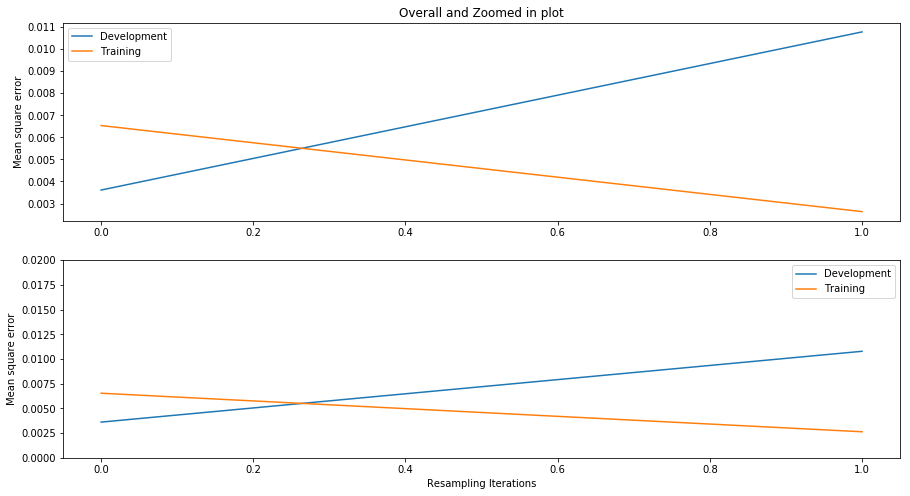

In [25]:
plt.figure(figsize = (15,8))
plt.subplot(2, 1, 1)
plt.plot(dev_acc)
plt.plot(train_acc)
plt.ylabel('Mean square error')
plt.legend(["Development","Training"])
plt.title("Overall and Zoomed in plot")

plt.subplot(2, 1, 2)
plt.plot(dev_acc)
plt.plot(train_acc)
plt.xlabel('Resampling Iterations')
plt.ylabel('Mean square error')
plt.legend(["Development","Training"])
plt.ylim(0,0.02)
plt.show()

## VI. Exporting Results
#### Pickle dump the parameters as well as results on training and development set to a file for future training and testing

In [26]:
filehandler = open("training_parameters.pkl","wb")
pickle.dump((parameters,train_acc,dev_acc,train),filehandler)
filehandler.close()